In [2]:
# Figure 3

In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from matplotlib.gridspec import GridSpec
from scipy import stats

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# Open MDA8 O3 output for all three climate scenarios 

# Present-day
ref = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_ref_c48.MDA8_O3.april-august.nc4")
ref = ref*1e9 #ppbv
ref = tools.mask_ocean_c48(ref)
ref = ref.chunk({"sim": -1, "time": -1})

refSNOx = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refSNOx_c48.MDA8_O3.april-august.nc4")
refSNOx = refSNOx*1e9 #ppbv
refSNOx = tools.mask_ocean_c48(refSNOx)
refSNOx = refSNOx.chunk({"sim": -1, "time": -1})

# Future-high
refshort = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refshort_c48.MDA8_O3.april-august.nc4")
refshort = refshort*1e9 #ppbv
refshort = tools.mask_ocean_c48(refshort)
refshort = refshort.chunk({"sim": -1, "time": -1})

refSNOxshort = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_refSNOxshort_c48.MDA8_O3.april-august.nc4")
refSNOxshort = refSNOxshort*1e9 #ppbv
refSNOxshort = tools.mask_ocean_c48(refSNOxshort)
refSNOxshort = refSNOxshort.chunk({"sim": -1, "time": -1})

# Future-low
polshort = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_polshort_c48.MDA8_O3.april-august.nc4")
polshort = polshort*1e9 #ppbv
polshort = tools.mask_ocean_c48(polshort)
polshort = polshort.chunk({"sim": -1, "time": -1})

polSNOxshort = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.all_polSNOxshort_c48.MDA8_O3.april-august.nc4")
polSNOxshort = polSNOxshort*1e9 #ppbv
polSNOxshort = tools.mask_ocean_c48(polSNOxshort)
polSNOxshort = polSNOxshort.chunk({"sim": -1, "time": -1})


In [5]:
def calc_region_mean(ds, months, region_num):
    """Helper function to compute regional mean for given dataset."""
    selected = ds["SpeciesConc_O3"].sel(time=ds["SpeciesConc_O3"].time.dt.month.isin(months))
    if "lev" in ds.dims:
        ds = ds.isel(lev=0, drop=True)
    region = tools.crop_regionmask_ar6_c48(selected, region_num)
    return region.mean(dim=["nf", "Xdim", "Ydim"])

def get_values(months, region_num):
    # List of datasets to process
    datasets = {
        'ref': ref,
        'refSNOx': refSNOx,
        'refshort': refshort,
        'refSNOxshort': refSNOxshort,
        'polshort': polshort,
        'polSNOxshort': polSNOxshort
    }
    
    # Compute regional means for all datasets
    means = {name: calc_region_mean(ds, months, region_num) for name, ds in datasets.items()}

    # Calculate the 95th percentile for each year (i.e. each April-August season)
    ref_95th = means['ref'].resample(time='1Y').quantile(0.95, dim="time")
    ref_95th_mean = ref_95th.median(dim=['sim','time']).values
    print(ref_95th_mean) # print for labeling later
    
    # Calculate days above the median historical 95th percentile for each dataset
    days_above_95 = {}
    for name, mean_data in means.items():
        # Set threshold
        condition = mean_data > ref_95th_mean
        # Count days exceeding ref_95th_mean
        days_above = mean_data.where(condition).resample(time='1Y').count(dim='time') # count number of high O3 days per season
        total_days = mean_data.resample(time='1Y').count(dim='time') # calc total number of days in April-August (= 153 days)
        days_above_95[name] = (days_above.values.flatten()/(total_days.values.flatten()))*100 # percent of days per season

    # Return results
    return (days_above_95['ref'], days_above_95['refSNOx'], days_above_95['refshort'],
            days_above_95['refSNOxshort'], days_above_95['polshort'], days_above_95['polSNOxshort'])

In [6]:
def bootstrap_ci(data, n_bootstrap=10000, ci=95):
    """
    Compute bootstrapped confidence intervals for the mean.
    """
    boot_means = np.array([np.nanmean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstrap)])
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    
    central = np.mean(data)
    return [central - lower, upper - central]  # Negative and positive errors


def plot_bars(months, region_num, ax):
    results = get_values(months, region_num)

    # Compute means and bootstrapped 95% confidence intervals
    means = [np.median(result) for result in results]
    stds = [bootstrap_ci(result) for result in results]

    # Barplot settings
    bar_props = [
        {'color': 'grey',      'edgecolor': 'black',     'hatch': None,  'label': 'Historical-BASE',         'text_color': 'black'},
        {'color': 'white',     'edgecolor': 'black',     'hatch': '////',  'label': 'Historical-LOWNOx',    'text_color': 'black'},
        {'color': 'red',       'edgecolor': 'red',       'hatch': None,  'label': 'High-Warming-BASE',       'text_color': 'red'},
        {'color': 'white',     'edgecolor': 'red',       'hatch': '////',  'label': 'High-Warming-LOWNOx',  'text_color': 'red'},
        {'color': 'dodgerblue','edgecolor': 'dodgerblue','hatch': None,  'label': 'Low-Warming-BASE',        'text_color': 'dodgerblue'},
        {'color': 'white',     'edgecolor': 'dodgerblue','hatch': '////',  'label': 'Low-Warming-LOWNOx',   'text_color': 'dodgerblue'}
    ]
    
    bar_width = 0.2
    x_positions = [i * bar_width for i in range(len(means))]

    # Plot bars and annotate mean value
    for x, mean, err, props in zip(x_positions, means, stds, bar_props):
        ax.bar(x, mean, width=bar_width, color=props['color'], alpha=1.0, 
               edgecolor=props['edgecolor'], hatch=props['hatch'], label=props['label'], 
               yerr=[[err[0]], [err[1]]], capsize=2) 
        ax.text(x + 0.05 * bar_width / 2, mean+err[1], f"{mean:.1f}", ha='center', va='bottom', 
                fontsize=7, color=props['text_color'])

    return ax

[69.13716401]
[62.47895967]
[70.75053368]


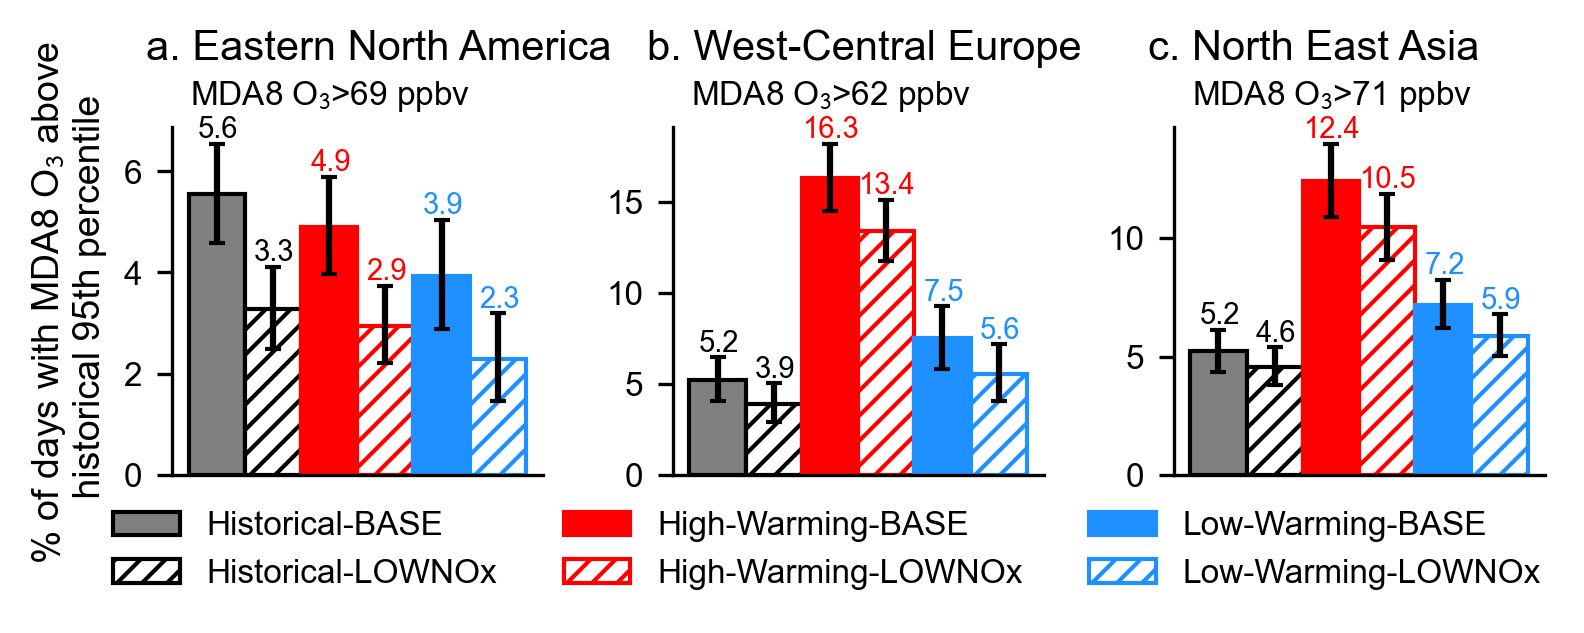

In [7]:
tools.set_matplotlib_font("Arial")

fig_width_in = 5.2
fig_height_in = 2.0

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

gs1 = GridSpec(1, 3, top=0.81, bottom=0.23, left=0.11, right=0.99, hspace=0.2, wspace=0.35)
ax0 = fig.add_subplot(gs1[0, 0])
ax1 = fig.add_subplot(gs1[0, 1])
ax2 = fig.add_subplot(gs1[0, 2])

ax = [ax0, ax1, ax2]
titles = [
    "a. Eastern North America", "b. West-Central Europe", "c. North East Asia",
]
extremes =['MDA8 O$_3$>69 ppbv', 'MDA8 O$_3$>62 ppbv', 'MDA8 O$_3$>71 ppbv'] # note that this is hardcoded

# Plotting
plot_bars([4,5,6,7,8], 5, ax[0])
plot_bars([4,5,6,7,8], 17, ax[1])
plot_bars([4,5,6,7,8], 58, ax[2])

# Y-label
ylabel = "% of days with MDA8 O$_3$ above \n historical 95th percentile"
ax0.set_ylabel(ylabel, fontsize=9)

# Axis settings
for idx, axis in enumerate(ax):
    axis.spines[['right', 'top']].set_visible(False)
    axis.tick_params(axis='both', labelsize=8)  
    axis.tick_params(labelbottom=False)
    axis.tick_params(bottom = False) 
    axis.tick_params(axis='both', labelsize=8)  
    axis.text(
        -0.07, 1.28, titles[idx], # print titles
        ha='left', 
        va='top',
        transform=axis.transAxes,
        color='black', 
        fontsize=10)
    axis.text(
        0.05, 1.14, extremes[idx], # print extremes
        ha='left', 
        va='top',
        transform=axis.transAxes,
        color='black', 
        fontsize=8)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.53, 0.22), fontsize=8, frameon=False)

################################
plt.savefig("Fig3_new.pdf")
